In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, naive_bayes, svm, neighbors, metrics
from sklearn.model_selection import train_test_split

In [6]:
def features_labels_split(dataframe:pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    return dataframe.iloc[:, :-1], dataframe.iloc[:, -1]

# Задание 1
Исследуйте, как объем обучающей выборки и количество тестовых данных, влияет на точность классификации в датасетах про крестики-нолики (tic_tac_toe.txt) и о спаме e-mail сообщений (spam.csv) с помощью наивного Байесовского классификатора. Постройте графики зависимостей точности на обучающей и тестовой выборках в зависимости от их соотношения.

In [ ]:
TIC_TAC_TOE_CONVERSION = {
    'o': -1,
    'b': 0,
    'x': 1,
    'positive': 1,
    'negative': -1
}

def load_tic_tac_toe():

    def cell_converter(cell_val):
        return TIC_TAC_TOE_CONVERSION[cell_val]
    
    def result_converter(result):
        return TIC_TAC_TOE_CONVERSION[result]

    col_names = ['(0;0)', '(0;1)', '(0;2)', '(1;0)', '(1;1)', '(1;2)', '(2;0)', '(2;1)', '(2;2)', 'x_win']
    converters = {}

    for i in col_names[:-1]:
        converters[i] = cell_converter
    converters[col_names[-1]] = result_converter
    
    path = os.path.join(os.readlink('./requisites'), 'tic_tac_toe.txt')
    df = pd.read_table(path, names=col_names, sep=',', converters=converters)
    
    return df

In [ ]:
SPAM_CONVERSION = {'spam': 1, 'nonspam': -1}

def load_spam():
    path = os.path.join(os.readlink(path='./requisites'), 'spam.csv')
    df = pd.read_table(path, sep=',', index_col=0, converters={'type': lambda x: SPAM_CONVERSION[x]})
    return df

In [ ]:
ttt_dataset, spam_dataset = load_tic_tac_toe(), load_spam()

ttt_features, ttt_labels = features_labels_split(ttt_dataset)
spam_features, spam_labels = features_labels_split(spam_dataset)

In [ ]:
def scores(dataset: pd.core.frame.DataFrame) -> dict:
    X, y = features_labels_split(dataset)
    
    results = {'train': {}, 'test': {}}

    for i in range(0,101,5):
        percent = (i if i > 0 else 1) if i < 100 else 99
        ratio = percent / 100
        
        classifier = naive_bayes.GaussianNB()

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio)

        classifier.fit(X_train, y_train)
        results['train'][percent] = classifier.score(X_train, y_train)
        results['test'][percent] = classifier.score(X_test, y_test)
    
    return results

In [ ]:
results = {'ttt': scores(ttt_dataset), 'spam': scores(spam_dataset)}

In [ ]:
def plot_res(results: dict, ds_name: str):
    x = [(i if i > 0 else 1) if i < 100 else 99 for i in range(0, 101, 5)]
    y_train = [results['train'][i] for i in x]
    y_test = [results['test'][i] for i in x]
    fig = plt.figure(figsize=(20,6))
    fig.suptitle(ds_name+' statistics', fontsize='xx-large')
    train_ax = fig.add_subplot(121)
    train_ax.set_title('Train accuracy')
    train_ax.set_xlabel('Test split size (%)')
    train_ax.set_ylabel('Accuracy')
    test_ax = fig.add_subplot(122)
    test_ax.set_title('Test accuracy')
    test_ax.set_xlabel('Test split size (%)')
    test_ax.set_ylabel('Accuracy')
    train_ax.plot(x, y_train)
    test_ax.plot(x, y_test)
    plt.show()

plot_res(results['ttt'], 'Tic-Tac-Toe')
plot_res(results['spam'], 'Spam')

# Задание 2
Сгенерируйте 100 точек с двумя признаками X1 и X2 в соответствии с нормальным распределением так, что одна и вторая часть точек (класс -1 и класс 1) имеют параметры: мат. ожидание X1, мат. ожидание X2, среднеквадратические отклонения для обеих переменных, соответствующие вашему варианту (указан в таблице). Построить диаграммы, иллюстрирующие данные. Построить Байесовский классификатор и оценить качество классификации с помощью различных методов (точность, матрица ошибок, ROСи PR-кривые). Является ли построенный классификатор «хорошим»?

In [ ]:
positive = np.array([np.random.normal(loc=9, scale=4, size=70), np.random.normal(loc=14, scale=4, size=70)])
negative = np.array([np.random.normal(loc=21, scale=3, size=30), np.random.normal(loc=3, scale=3, size=30)])

In [ ]:
plt.plot(positive[0], positive[1], 'bo', negative[0], negative[1], 'ro')
plt.legend(['positive', 'negative'], loc='upper right')
plt.show()

In [ ]:
def reshaped(data) -> list:
    return [(data[0][i], data[1][i]) for i in range(len(data[0]))]

In [ ]:
data = reshaped(positive)
data.extend(reshaped(negative))
labels = [1. if i < 70 else -1. for i in range(100)]
train_data, test_data, train_labels, test_labels = train_test_split(data, labels)
classifier = naive_bayes.GaussianNB()
classifier.fit(train_data, train_labels)

In [ ]:
print(classifier.score(test_data, test_labels))
metrics.plot_confusion_matrix(classifier, test_data, test_labels)
metrics.plot_roc_curve(classifier, test_data, test_labels)
metrics.plot_precision_recall_curve(classifier, test_data, test_labels)

# Задание 3
Постройте классификатор на основе метода k ближайших соседей для обучающего множества Glass (glass.csv). Посмотрите заголовки признаков и классов. Перед построением классификатора необходимо также удалить первый признак Id number, который не несет никакой информационной нагрузки.

In [ ]:
conversion_dict = {'spam': 1., 'nonspam': -1.}

data = pd.read_csv(os.path.join(os.readlink(path='./requisites'), 'glass.csv'), index_col=0, converters={'type': lambda x: conversion_dict[x]})

X, y = features_labels_split(dataframe=data)
X_train, X_test, y_train, y_test = train_test_split(X, y)

## a.
Постройте графики зависимости ошибки классификации от количества ближайших соседей.

In [ ]:
plot_y = []
for neighbors_count in range(1, min(len(X_train), len(X_test)), 2):
    classifier = neighbors.KNeighborsClassifier(n_neighbors=neighbors_count, n_jobs=-1)
    classifier.fit(X_train, y_train)
    plot_y.append(classifier.score(X_test, y_test))
plot_x = list(range(1, min(len(X_train), len(X_test)), 2))

plt.plot(plot_x, plot_y)

## b.
Определите подходящие метрики расстояния и исследуйте, как тип метрики расстояния влияет на точность классификации.

In [ ]:
print(plot_x[plot_y.index(max(plot_y))])

In [ ]:
'''
Possible metrics
    Euclidean - simple distance
    Manhattan - sum of absolute values of diffs
    Chtbyshev - max of absolute values of diffs
    Minkowski - differs between manhhattan and chebyshev
'''
results = {'euclidean': 0., 'manhattan': 0., 'chebyshev': 0., 'minkowski': 0.}
for metric in results.keys():
    params = {}
    if metric == 'minkowski':
        params['p'] = 1
    classifier = neighbors.KNeighborsClassifier(n_neighbors=5, n_jobs=-1, metric=metric, metric_params=params)
    classifier.fit(X_train, y_train)
    results[metric] = classifier.score(X_test, y_test)
x = np.arange(len(results))
plot_labels, plot_y = sorted(results.keys()), [results[i] for i in sorted(results.keys())]
plt.bar(x, plot_y)
plt.xticks(x, plot_labels)

## c.
Определите, к какому типу стекла относится экземпляр с характеристиками: RI=1.516 Na=11.7 Mg=1.01 Al=1.19 Si=72.59 K=0.43 Ca=11.44 Ba=0.02 Fe=0.1

In [ ]:
classifier.predict([(1.516, 11.7, 1.01, 1.19, 72.59, 0.43, 11, 0.02, 0.1)])

# Задание 4
Постройте классификаторы на основе метода опорных векторов для наборов данных из файлов svmdataN.txt и svmdataNtest.txt, где N – индекс задания:

## a.
Постройте алгоритм метода опорных векторов с линейным ядром. Визуализируйте разбиение пространства признаков на области с помощью полученной модели ([пример визуализации](https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html)). Выведите количество полученных опорных векторов, а также матрицу ошибок классификации на обучающей и тестовой выборках.

In [56]:
def load_data(filename):
    conversion_dict = {'red': 1., 'green': -1.}
    dir_path = '../lab1/requisites'
    full_path = os.path.join(os.readlink(path=dir_path), filename)
    data = pd.read_table(full_path, index_col=0, sep='\t', converters={'Colors': lambda x: conversion_dict[x]})
    return features_labels_split(dataframe=data)

In [57]:
def color_transformed(values):
    conversion_dict = {1.: 'red', -1: 'green'}
    return np.vectorize(lambda x: conversion_dict[x])(values)

In [74]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in"""

    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

In [75]:
def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier."""

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [76]:
X_train, y_train = map(lambda x: x.to_numpy(), load_data(filename='svmdata_a.txt'))

X_test, y_test = map(lambda x: x.to_numpy(), load_data(filename='svmdata_a_test.txt'))

In [77]:
classifier = svm.SVC(kernel='linear')
classifier.fit(X_train, y_train)

SVC(kernel='linear')

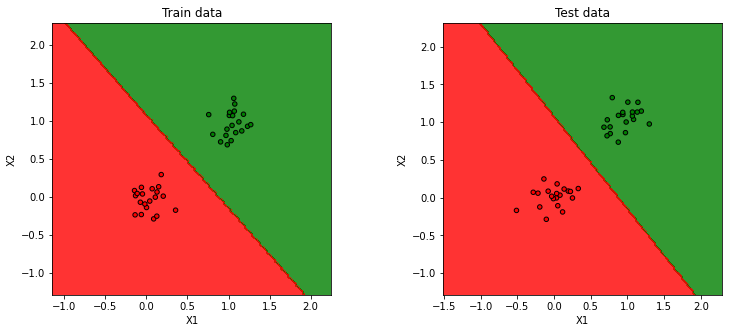

In [78]:
# title for the plots
titles = ('Train data', 'Test data')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)


for title, ax, X, y in zip(titles, sub.flatten(), (X_train, X_test), (y_train, y_test)):
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, classifier, xx, yy, colors=np.unique(color_transformed(y)), alpha=0.8)
    ax.scatter(X0, X1, c=color_transformed(y), s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_title(title)

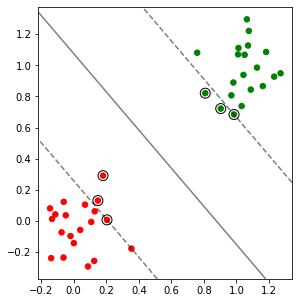

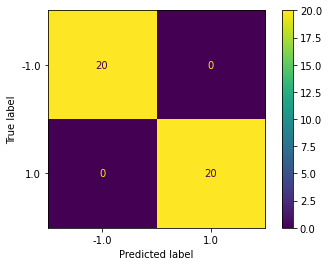

In [79]:
support_vectors = classifier.support_vectors_

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X_train[:, 0], X_train[:, 1], c=color_transformed(y_train), s=30)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                        np.linspace(ylim[0], ylim[1], 50))
Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='k')

metrics.plot_confusion_matrix(classifier, X_test, y_test)

## b.
Постройте алгоритм метода опорных векторов с линейным ядром. Добейтесь нулевой ошибки сначала на обучающей выборке, а затем на тестовой, путем изменения штрафного параметра. Выберите оптимальное значение данного параметра и объясните свой выбор. Всегда ли нужно добиваться минимизации ошибки на обучающей выборке?

In [80]:
X_train, y_train = map(lambda x: x.to_numpy(), load_data(filename='svmdata_b.txt'))

X_test, y_test = map(lambda x: x.to_numpy(), load_data(filename='svmdata_b_test.txt'))

In [88]:
C = 1.
while True:
    classifier = svm.SVC(kernel='linear', C=C)
    classifier.fit(X_train, y_train)
    print(classifier.score(X_train, y_train), C, end='\r')
    if classifier.score(X_train, y_train) == 1.:
        break
    else:
        C += 1.

1.0 483.0

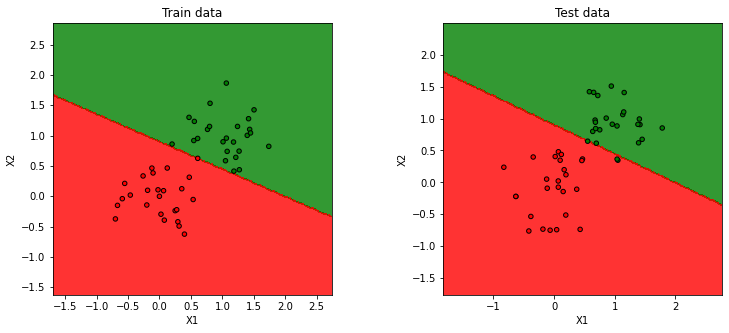

In [89]:
# title for the plots
titles = ('Train data', 'Test data')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for title, ax, X, y in zip(titles, sub.flatten(), (X_train, X_test), (y_train, y_test)):
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, classifier, xx, yy, colors=np.unique(color_transformed(y)), alpha=0.8)
    ax.scatter(X0, X1, c=color_transformed(y), s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_title(title)

In [90]:
C = 1.
while True:
    classifier = svm.SVC(kernel='linear', C=C)
    classifier.fit(X_test, y_test)
    print(classifier.score(X_test, y_test), C, end='\r')
    if classifier.score(X_test, y_test) == 1.:
        break
    else:
        C += 1.

1.0 1.0

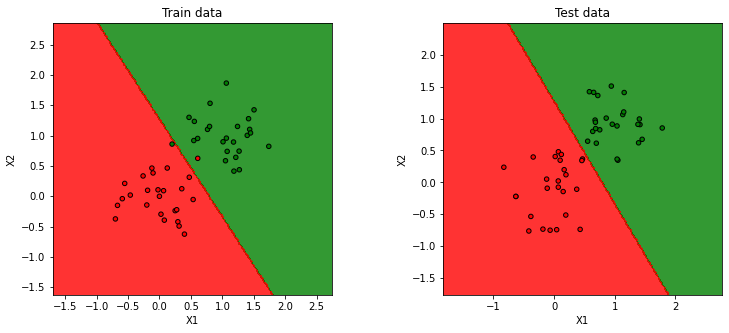

In [91]:
# title for the plots
titles = ('Train data', 'Test data')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for title, ax, X, y in zip(titles, sub.flatten(), (X_train, X_test), (y_train, y_test)):
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, classifier, xx, yy, colors=np.unique(color_transformed(y)), alpha=0.8)
    ax.scatter(X0, X1, c=color_transformed(y), s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_title(title)

## c.
Постройте алгоритм метода опорных векторов, используя различные ядра (линейное, полиномиальное степеней 1-5, сигмоидальная функция, гауссово). Визуализируйте разбиение пространства признаков на области с помощью полученных моделей. Сделайте выводы.

## d.
Постройте алгоритм метода опорных векторов, используя различные ядра (полиномиальное степеней 1-5, сигмоидальная функция, гауссово). Визуализируйте разбиение пространства признаков на области с помощью полученных моделей. Сделайте выводы.

## e.
Постройте алгоритм метода опорных векторов, используя различные ядра (полиномиальное степеней 1-5, сигмоидальная функция, гауссово). Изменяя значение параметра ядра (гамма), продемонстрируйте эффект переобучения, выполните при этом визуализацию разбиения пространства признаков на области.

# Задание 5
Постройте классификаторы для различных данных на основе деревьев решений:

## a.
Загрузите набор данных Glass из файла glass.csv. Постройте дерево классификации для модели, предсказывающей тип (Type) по остальным признакам. Визуализируйте результирующее дерево решения. Дайте интерпретацию полученным результатам. Является ли построенное дерево избыточным? Исследуйте зависимость точности классификации от критерия расщепления, максимальной глубины дерева и других параметров по вашему усмотрению.

## b.
Загрузите набор данных spam7 из файла spam7.csv. Постройте оптимальное, по вашему мнению, дерево классификации для параметра yesno. Объясните, как был осуществлён подбор параметров. Визуализируйте результирующее дерево решения.Определите наиболее влияющие признаки. Оцените качество классификации.

# Задание 6
Загрузите набор данных из файла bank_scoring_train.csv. Это набор финансовых данных, характеризующий физических лиц. Целевым столбцом является «SeriousDlqin2yrs», означающий, ухудшится ли финансовая ситуация у клиента. Постройте систему по принятию решения о выдаче или невыдаче кредита физическому лицу. Сделайте как минимум 2 варианта системы на основе различных классификаторов. Подберите подходящую метрику качества работы системы исходя из специфики задачи и определите, принятие решения какой системой сработало лучше на bank_scoring_test.csv.